In [1]:
import Global_Functions as gf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import Neuronal_Networks as nn
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

In [2]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [3]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [4]:
experiments = [ex_1, ex_4, ex_9, ex_20, ex_21, ex_22, ex_23, ex_24]
names = ['1', '4', '9', '20', '21','22', '23', '24']

In [5]:
NEUR = 128
EPOCH = 1000
LAG = 60

train = "22"
val = "24"

ex_train = ex_22
ex_val = ex_24

In [6]:
image_path = "../Images/"
image_subfolder = image_path + "Endtime/"
specs = "training_{0} val_{1} {2}_neurons__{3}_epochs__lag_{4}/" 
image_folder = image_subfolder + timestr + "_" + specs.format(train, val, NEUR, EPOCH, LAG) 

gf.check_folder(image_path)
gf.check_folder(image_subfolder)
gf.check_folder(image_folder)

Folder already exists.
Folder already exists.
Creation of directory ../Images/Endtime/2021-04-08_10-17_training_22 val_24 128_neurons__1000_epochs__lag_60/ successful.


In [7]:
def get_ends(col, delta = 60, epsilon = 10):
    end_splits = list()
    first = True
    for x in range(delta, len(col)):
        part = col[x-delta:x]
        part_mean = np.mean(part)
        if 0-epsilon <= part_mean <= 0+epsilon:
            if first:
                end_splits.append(x-delta)
                first = False
        elif part_mean < -3*epsilon or part_mean > 3*epsilon:
            first = True
    return end_splits

In [8]:
def get_splits(df, delta = 60, epsilon = 10):
    input_splits = [x for x in range(len(df)-1) if df.iloc[x]['input_voltage'] != df.iloc[x+1]['input_voltage']]
    df['diff_el_power'] = df.diff(delta)['el_power']
    df['diff_el_power'][:delta] = 0
    end_splits = get_ends(df['diff_el_power'], delta, epsilon)
    return input_splits, end_splits

In [9]:
def analyse_splits(experiment, name, delta = 60, epsilon = 10):
    input_splits, end_splits = get_splits(experiment, delta = delta, epsilon = epsilon)
    plt.plot(experiment['el_power'])
    for i in input_splits:
        plt.axvline(i, color = 'green')
    for j in end_splits:
        plt.axvline(j, color = 'red')
    plt.savefig(image_folder + 'experiment '+ name + '.png')

In [10]:
def create_data_from_splits(experiment):
    inputs, endsplits = get_splits(experiment)
    df = pd.DataFrame(index=range(len(inputs)), columns=['voltage_start', 'voltage_end', 'power_start', 'power_end', 'time_start', 'time_end'])
    for i in range(len(inputs)):
        df['voltage_start'][i] = experiment['input_voltage'].iloc[inputs[i]]
        df['voltage_end'][i] = experiment['input_voltage'].iloc[inputs[i]+1]
        df['power_start'][i] = experiment['el_power'].iloc[inputs[i]]
        df['power_end'][i] = experiment['el_power'].iloc[inputs[i]-1]
        df['time_start'][i] = inputs[i]
        df['time_end'][i] = endsplits[np.argmax(np.array(endsplits) > inputs[i])]
    X = df[['voltage_start', 'voltage_end', 'time_start']]
    y = df[['time_end', 'power_end']]
    
    X = X.values
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    y = y.values
    y = y.reshape(y.shape[0], 1, y.shape[1])
    
    X=np.asarray(X).astype(np.int)
    y=np.asarray(y).astype(np.int)
    return X,y

In [11]:
def fit_time_model(df_train, df_val, batch_size, nb_epochs, neurons):
    X_train, y_train = create_data_from_splits(df_train)
    X_val, y_val = create_data_from_splits(df_val)
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
    history = list()

    model = Sequential()
    model.add(layers.Dense(neurons))
    model.add(layers.Dense(neurons/2))
    model.add(layers.Dense(2))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', )
    for i in range(nb_epochs):
        model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1, batch_size = batch_size, verbose = 1, shuffle = False, callbacks = [es])
        model.reset_states()
    return model, history

In [12]:
model_time, history = fit_time_model(ex_train, ex_val, 1, EPOCH, NEUR)

144/144 [==============================] - 0s 832us/step - loss: 613370.8750 - val_loss: 1055451.6250


144/144 [==============================] - 0s 855us/step - loss: 153931.3750 - val_loss: 796454.8750


144/144 [==============================] - 0s 825us/step - loss: 139140.6094 - val_loss: 475746.9375


  1/144 [..............................] - ETA: 0s - loss: 185995.4844WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_begin` time: 0.0010s). Check your callbacks.


  1/144 [..............................] - ETA: 0s - loss: 331616.1250WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_begin` time: 0.0010s). Check your callbacks.


144/144 [==============================] - 0s 861us/step - loss: 108440.2188 - val_loss: 567431.9375


144/144 [==============================] - 0s 854us/step - loss: 92746.2969 - val_loss: 458189.6250


  1/144 [..............................] - ETA: 0s - loss: 135832.0625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0010s). Check your callbacks.


144/144 [==============================] - 0s 861us/step - loss: 130132.9062 - val_loss: 677277.8125


108/144 [=====================>........] - ETA: 0s - loss: 99375.7344 WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.


144/144 [==============================] - 0s 840us/step - loss: 81438.9844 - val_loss: 394706.8125


144/144 [==============================] - 0s 820us/step - loss: 79262.3516 - val_loss: 402557.6875


144/144 [==============================] - 0s 820us/step - loss: 72389.7734 - val_loss: 355962.5938


  1/144 [..............................] - ETA: 0s - loss: 211325.1875WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0010s). Check your callbacks.


144/144 [==============================] - 0s 827us/step - loss: 71088.7500 - val_loss: 321480.9062


144/144 [==============================] - 0s 854us/step - loss: 79834.2812 - val_loss: 408011.6250


In [13]:
def predictions_time(experiment, model, name):
    X, y = create_data_from_splits(experiment)
    preds = model.predict(X)
    
    fig = plt.figure()
    plt.title('Comparison Endtime approach on experiment ' + name)
    plt.plot(experiment['el_power'], color = gf.get_color('grey'), label = 'power')
    
    first_i = True
    first_j = True
    for i in preds[:,0][:,0]:
        if first_i:
            plt.axvline(np.mean(i), color = gf.get_color('green'), label = 'predicted ends')
            first_i = False
        else:
            plt.axvline(np.mean(i), color = gf.get_color('green'))
    for j in y[:,0][:,0]:
        if first_j:
            plt.axvline(j, color = 'red', label = 'ends')
            first_j = False
        else:
            plt.axvline(j, color = 'red')
    plt.xlabel('Time [sec]')
    plt.ylabel('Electric Power [W]')
    plt.legend()
    plt.savefig(image_folder + 'experiment '+ name + '.png')

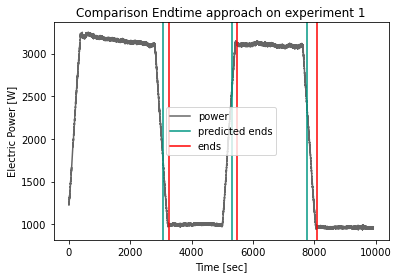

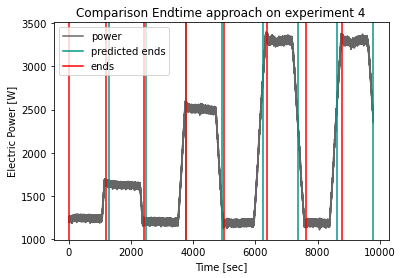

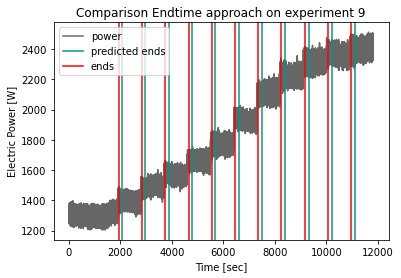

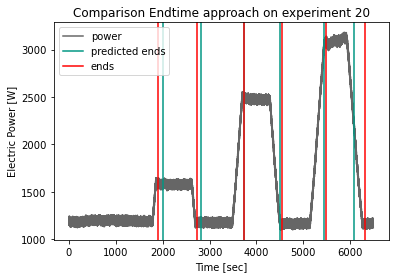

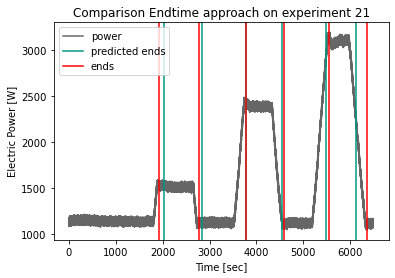

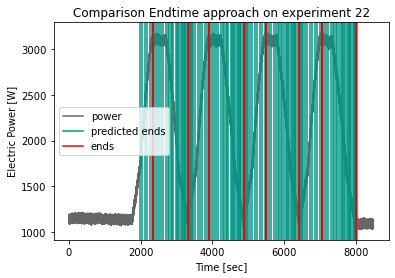

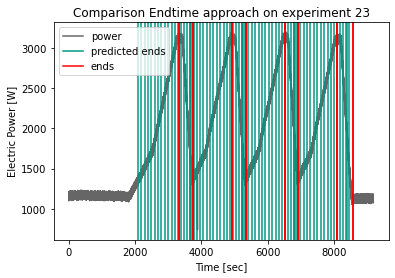

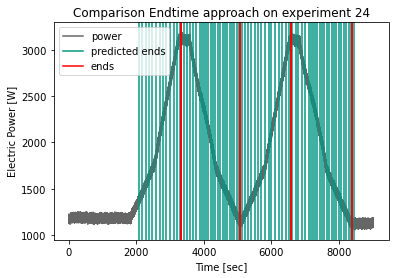

In [14]:
for i in range(len(names)):
    predictions_time(experiments[i], model_time, names[i])

In [15]:
def predict_power_based_on_time(experiment, model_time, name):
    input_splits, endsplits = get_splits(experiment)
    X, y = create_data_from_splits(experiment)
    preds = model_time.predict(X)
    voltage = []
    current = 1100
    
    for i in range(X.shape[0]-1):
        start = X[:,:,2][i][0]
        end = min(int(np.mean(preds[:,0][:,0][i])), X[:,:,2][i+1][0])
        voltage_start = X[:,:,0][i][0]
        voltage_end = X[:,:,1][i][0]
        for j in range(end-start):
            if voltage_end > voltage_start:
                current += 5
            elif voltage_end < voltage_start:
                current -= 5
            voltage.append(current)
            current = voltage[-1]
            
        for k in range(X[:,:,2][i+1][0] - end):
            voltage.append(current)
            
    start_plot = input_splits[0]
    length = min(len(experiment), len(voltage) + start_plot)
    
    fig, ax1 = plt.subplots()
    
    plt.title('Endtime approach with hand made differences on exp. ' + name)
    
    ax1.set_xlabel('Time [sec]')
    ax1.set_ylabel('Power [W]')
    ln_1 = ax1.plot(experiment['time'], experiment['el_power'], color = gf.get_color('grey'), label = 'true')
    ln_2 = ax1.plot(experiment['time'][start_plot:length], voltage[:length], color = gf.get_color('green'), label = 'predictions')
    ax1.tick_params(axis = 'y')
    
    ax2= ax1.twinx()
    ax2.set_ylabel('Voltage [V]')
    ln_3 = ax2.plot(experiment['time'], experiment['input_voltage'], color = gf.get_color('blue'),label = 'input voltage')
    
    lns = ln_1 + ln_3 + ln_2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc = 'upper left')
    plt.savefig(image_folder + 'prediction power based on time '+ name + '.png')
    
    fig.tight_layout()
    plt.show()
    
    return voltage

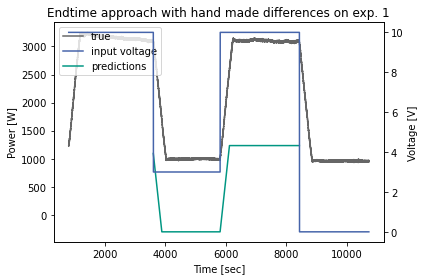

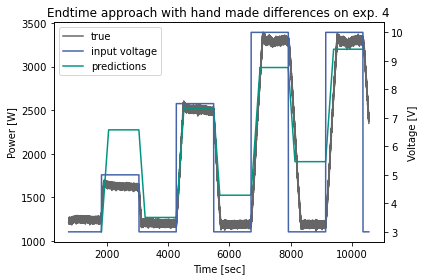

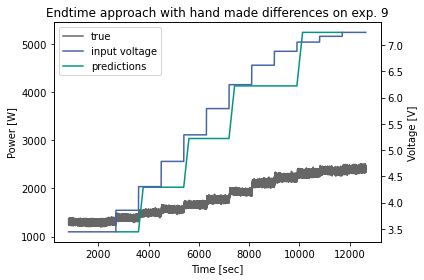

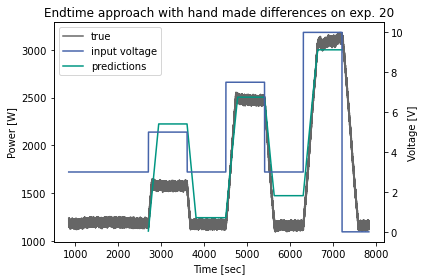

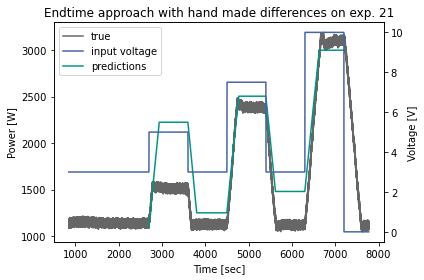

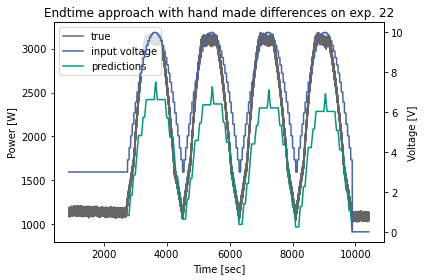

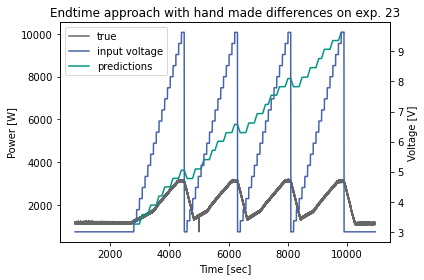

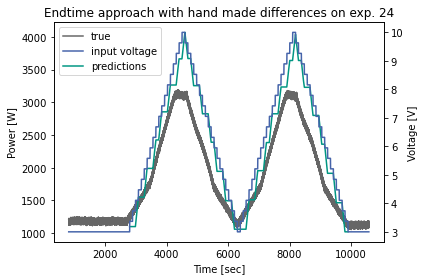

In [16]:
for i in range(len(names)):
    predict_power_based_on_time(experiments[i], model_time, names[i])

In [17]:
def predict_power(experiment, model_time, name):
    input_splits, endsplits = get_splits(experiment)
    X, y = create_data_from_splits(experiment)
    preds = model_time.predict(X)
    voltage = []
    current = 1100
    preds_time = [int(i) for i in preds[:,0][:,0]]
    preds_power = preds[:,0][:,1]
    dummy = input_splits
    for i in preds_time:
        dummy = np.append(dummy, i)
    dummy = dummy + experiment['time'][0]
    preds_time = np.sort(dummy)[:-1]
    preds_power = preds_power.repeat(2)
    preds_power = preds_power[1:]
    
    fig, ax1 = plt.subplots()
    
    plt.title('Predicted power with Endtime approach on exp. ' + name)
    
    ax1.set_xlabel('Time [sec]')
    ax1.set_ylabel('Power [W]')
    ln_1 = ax1.plot(experiment['time'], experiment['el_power'], color = gf.get_color('grey'), label = 'true')
    ln_2 = ax1.plot(preds_time, preds_power, color = gf.get_color('green'), label = 'predictions')
    ax1.tick_params(axis = 'y')
    
    ax2= ax1.twinx()
    ax2.set_ylabel('Voltage [V]')
    ln_3 = ax2.plot(experiment['time'], experiment['input_voltage'], color = gf.get_color('blue'),label = 'input voltage')
    
    lns = ln_1 + ln_3 + ln_2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels)
    plt.savefig(image_folder + 'prediction power '+ name + '.png')
    
    fig.tight_layout()
    plt.show()
    
    return voltage

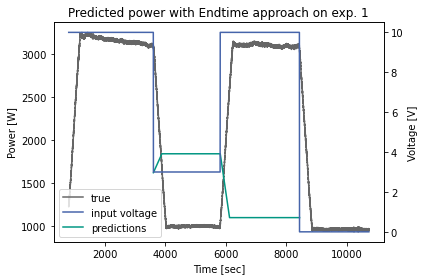

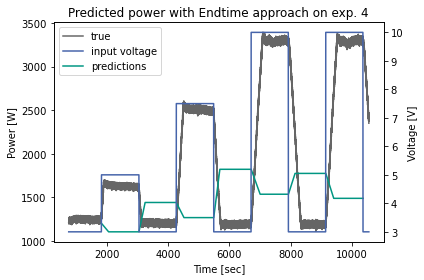

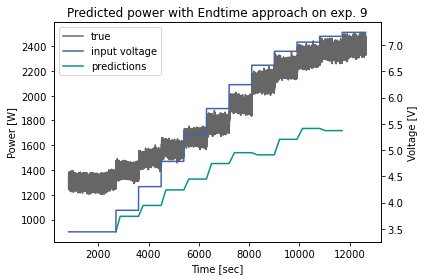

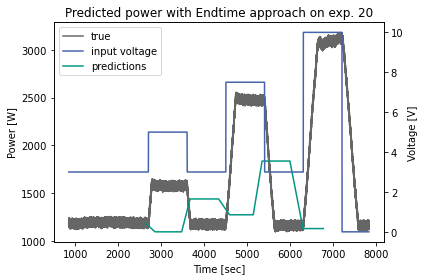

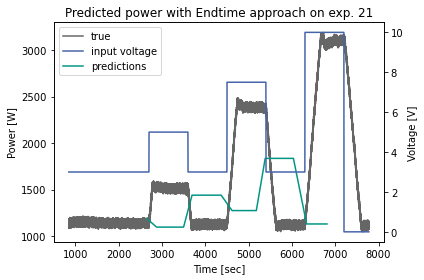

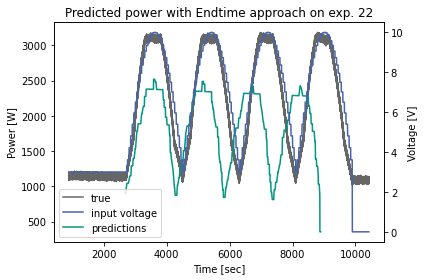

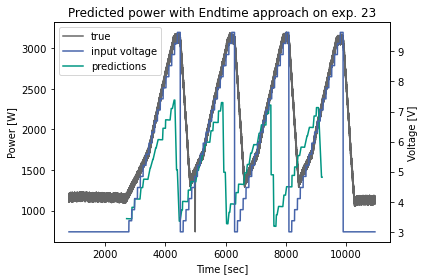

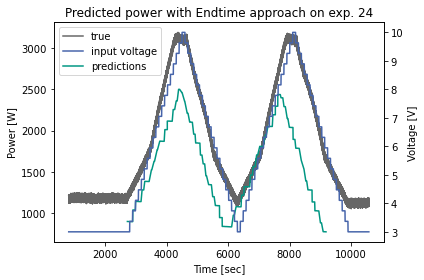

In [18]:
for i in range(len(names)):
    predict_power(experiments[i], model_time, names[i])